In [1]:
# Load libraries

# Compatibility between Python 2 and Python 3
from __future__ import division, print_function, unicode_literals, absolute_import

%matplotlib inline
import os
import math
import numpy as np
from brian2 import *

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

#from neurodynex.working_memory_network import wm_model
#from neurodynex.working_memory_network import wm_model_modified

from neurodynex.working_memory_network import wm_model_modified_simplified_EC_LV_principal

from neurodynex.tools import plot_tools

from utility_functions import *

import pandas as pd
from scipy.optimize import curve_fit # for doing regression
from sklearn.metrics import r2_score # for measuring fit error

from Python_Libs.utility_functions import *

SAVE_PLOT = False
figs_path = 'Data/Plots/'
figs_extension = '.svg'

collected_data_file = 'Data/collected_drift_trials_v4_all_EC_LV_3.npy' # The file to load the collected trials data from
collected_data_file = 'Data/collected_drift_trials_v4_all_EC_LV_5_20trials_duration60s.npy'
collected_data_file = 'Data/collected_drift_trials_v4_all_EC_LV_reduced_2_5_20trials_duration60s.npy'

In [2]:
input_path = '/Volumes/WD Elements 25A3 Media/Documents/Research/PhD/Projects/Recurrent_Net_Memory/Attractor_Based_Memory_Plaussibility_Study/'
input_file = 'collected-wrapped.npy' # This is the non unwrapped recordings
input_file = 'collected-wrapped-NMDA-EC_LV_1-bak27082021.npy' # This is the non unwrapped recordings
input_filename = os.path.join(input_path, input_file)

if os.path.exists(input_filename):
    # Save all data in the file
    data = np.load(input_filename, allow_pickle=True, encoding='bytes')
else: 
    print('ERROR: File does not exist: {:s}'.format(input_filename))

In [13]:
# The above loaded data from the file to the variable data has the following structure:
#     data[()][model][poisson_neuron_noise][neurons_num].keys()    (option 1)
#     data.item()[model][poisson_neuron_noise][neurons_num].keys() (option 2)
#          model = ['NMDA', 'EC_LV_1'][0]
#          poisson_neuron_noise = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009][0]
#          neurons_num = [128, 256, 512, 1024, 2048, 4096, 8192][0]
#  eg data.item()['NMDA'][0.001][1024]['theta_ts_list'] = time_series_collection
# The way to access and explore the dict entries in the the variable data is
#     data[()].keys()
#     or
#     data.item().keys()
model = ['NMDA', 'EC_LV_1'][0]
poisson_neuron_noise = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009][0]
neurons_num = [128, 256, 512, 1024, 2048, 4096, 8192][0]
data.item()[model][poisson_neuron_noise][neurons_num].keys()

dict_keys(['theta_ts_list', 'theta_ts_abs_diff_mean', 'theta_ts_abs_diff_std', 't_snapshots', 'stimulus_center_deg', 'N_excitatory', 'idx_monitored_neurons_excit', 'theta_mean_absolute_deviation_rate'])

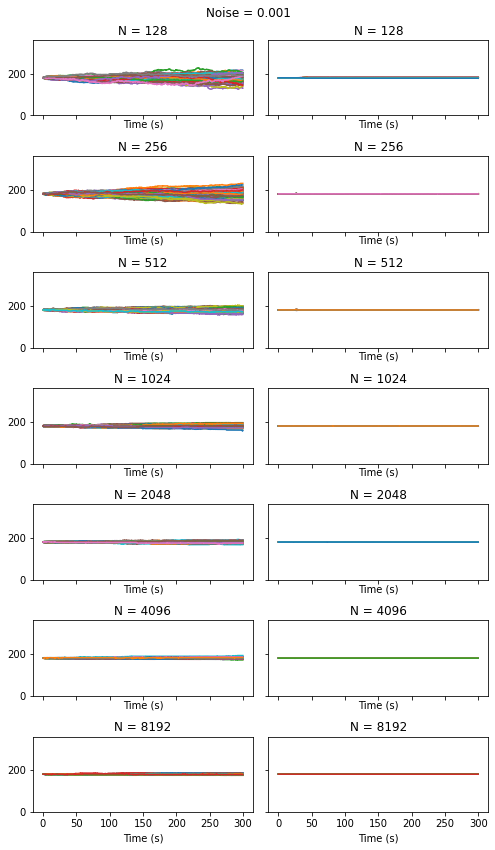

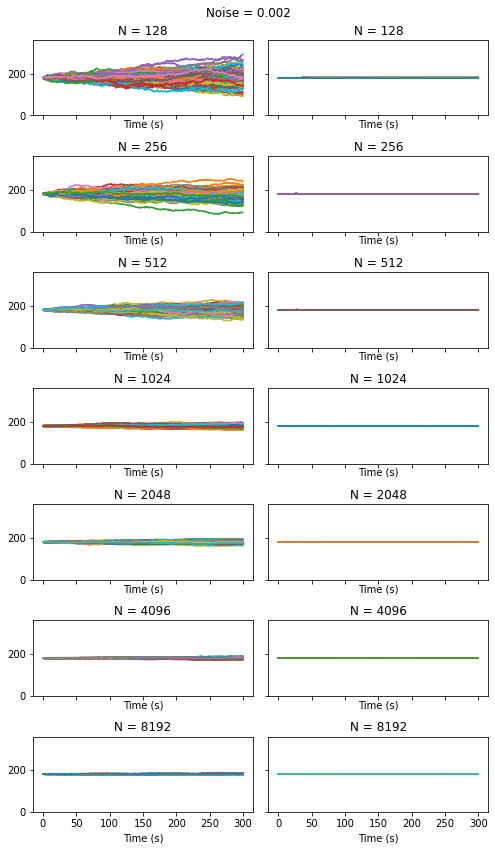

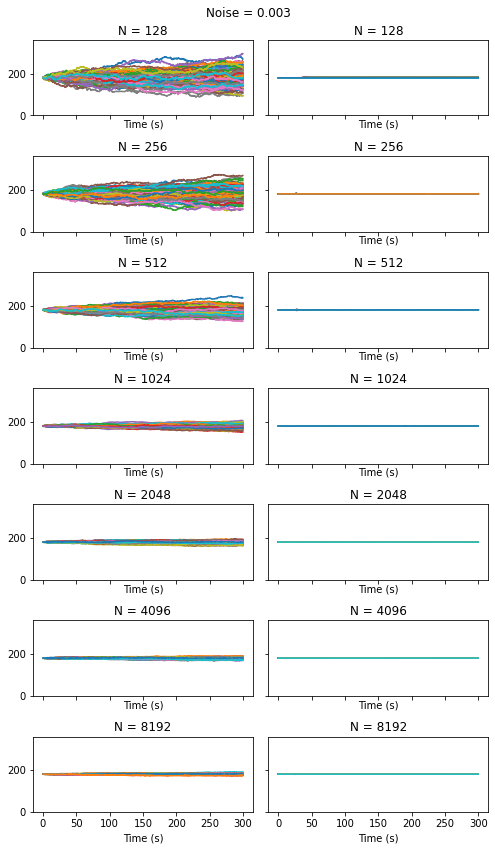

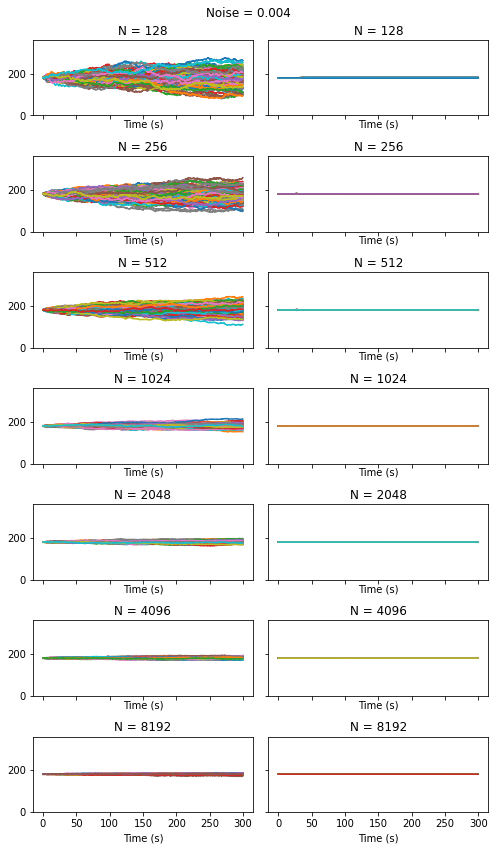

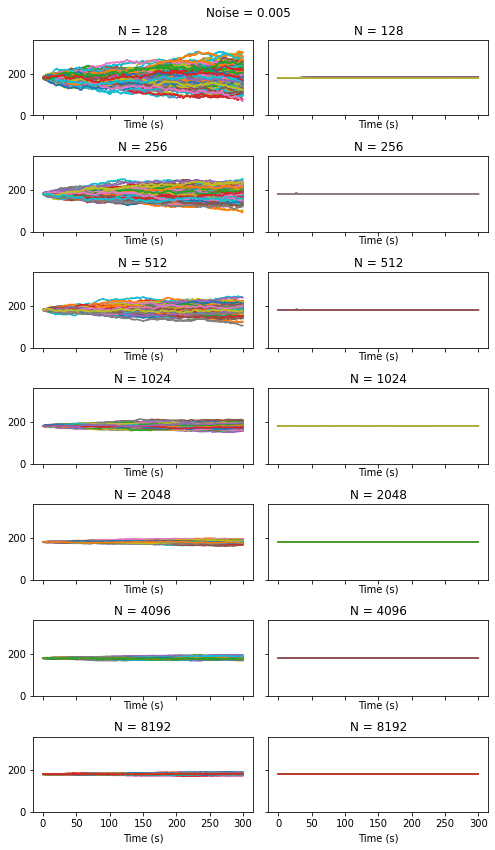

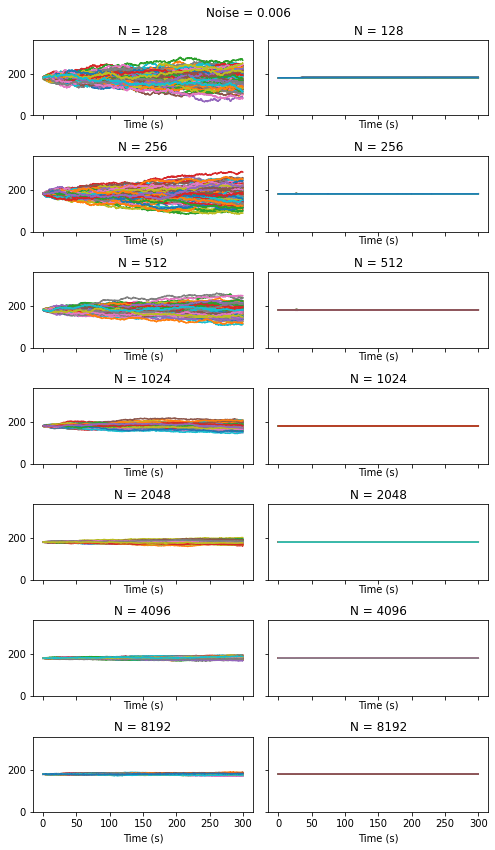

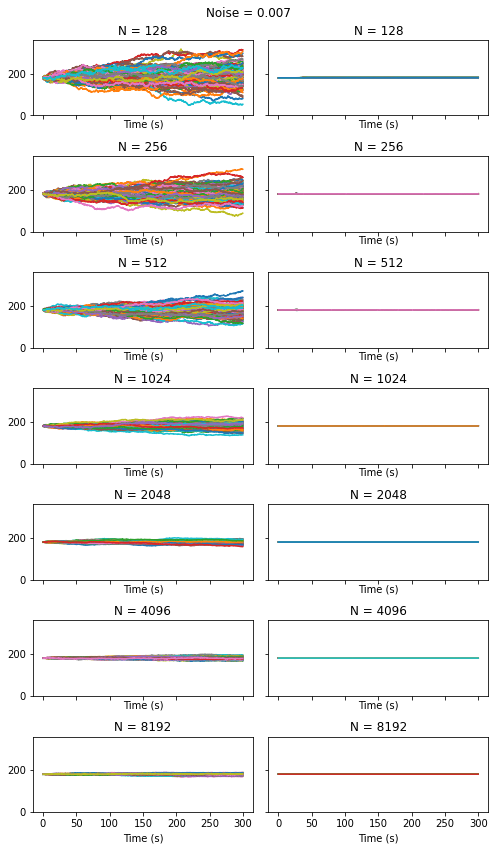

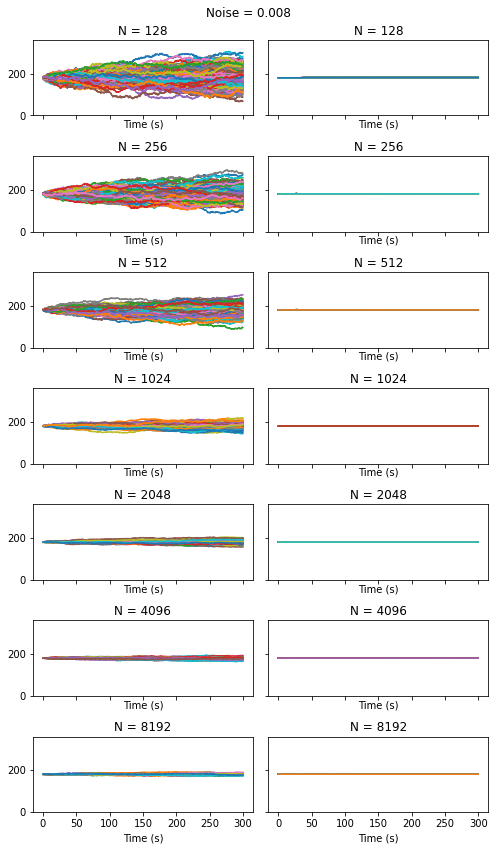

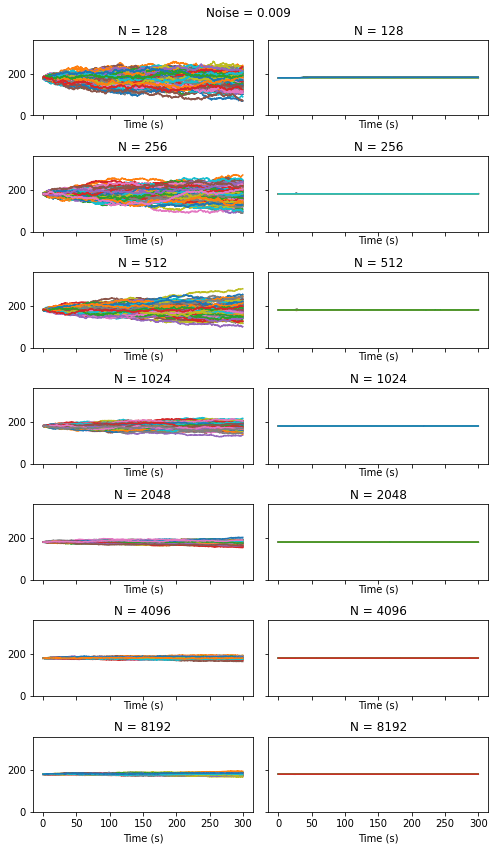

In [41]:
# Plot each experimental condition in separate plot

# Choose what to plot
plot_types = ['theta', 'abs_diff_mean', 'abs_diff_std']
plot_type = plot_types[0]                       # Choose what to plot 
                                                #       'theta': theta_ts_list, 
                                                #       'abs_diff_mean': theta_ts_abs_diff_mean, 
                                                #       'abs_diff_std': theta_ts_abs_diff_std

models = ['NMDA', 'EC_LV_1']  # List of the neuron models present in the collected recordings file
poisson_neuron_noises = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009] # List of the neuron noise present in the collected recordings file
neurons_nums = [128, 256, 512, 1024, 2048, 4096, 8192] # List of the network sizes present in the collected recordings file

model = models[0]                               # Choose which neuron model results to plot
poisson_neuron_noise = poisson_neuron_noises[0] # Choose what neuron noise results to plot
neurons_num = neurons_nums[0]                   # Choose which network size results to plot


for poisson_neuron_noise in poisson_neuron_noises:
    fig, axs = plt.subplots(nrows=len(neurons_nums), ncols=2, figsize=(7, 12), sharex=True, sharey=True)

    for indx_i, model in enumerate(models):
        for indx_j, neurons_num in enumerate(neurons_nums):
            # Get reference to the appropriate subplot
            ax = axs[indx_j, indx_i]
            # Get the list of theta recordings time series
            theta_ts_list = data[()][model][poisson_neuron_noise][neurons_num]['theta_ts_list']
            t_snapshots = data[()][model][poisson_neuron_noise][neurons_num]['t_snapshots']
            theta_ts_abs_diff_mean = data[()][model][poisson_neuron_noise][neurons_num]['theta_ts_abs_diff_mean']
            theta_ts_abs_diff_std = data[()][model][poisson_neuron_noise][neurons_num]['theta_ts_abs_diff_std']

            fig.suptitle('Noise = ' + str(poisson_neuron_noise))

            if plot_type == plot_types[0]: # Plot theta_ts_list
                for i, ts in enumerate(theta_ts_list):
                    ax.plot(t_snapshots, ts)
                    ax.set_title('N = ' + str(neurons_num))
                    ax.set_xlabel('Time (s)')
                    ax.set_ylim((0, 360))

            if plot_type == plot_types[1]: # Plot theta_ts_abs_diff_mean
                ax.plot(t_snapshots, theta_ts_abs_diff_mean)
                ax.set_title('N = ' + str(neurons_num))
                ax.set_xlabel('Time (s)')
                #ax.set_ylim((0, 360))

            if plot_type == plot_types[2]: # Plot theta_ts_abs_diff_std
                ax.plot(t_snapshots, theta_ts_abs_diff_std)
                ax.set_title('N = ' + str(neurons_num))
                ax.set_xlabel('Time (s)')
                #ax.set_ylim((0, 360))

    fig.tight_layout()

In [5]:
def scale_circ_to_line(theta_ts_list, scale=[(0, 360), (0, 100)]):
    """ Gets 
            theta_ts_list   : a list of an numpy array of arrays
            scale           : a list for conversion from a scale to another scale, eg [(0, 360), (0, 100)]
        Returns
            the time series with the samples scaled according to scale, from range scale[0] to range scale[1]
    """
    if isinstance(theta_ts_list, list):
        theta_ts_list = np.array(theta_ts_list)
    if scale is not None: 
        normalised_theta_ts_list = theta_ts_list / scale[0][1] # [0, 1]
        distance_represented = normalised_theta_ts_list * scale[1][1]
    else:
        distance_represented = theta_ts_list
    return distance_represented

def preprocess_time_series(time_series, t_snapshots, scale=None, plot_from_t=None, normalise_start=None):
    """ Gets 
            time_series     : a list or an numpy array of arrays
            t_snapshots     : an array with the time stamps of the samples in time_series (with units)
            scale           : a list for conversion from a scale to another scale, eg [(0, 360), (0, 100)]
            plot_from_t     : return samples from that time stamp onwards
            normalise_start : normalise all time series to this starting value
        Returns
            a touple with the t_snapshots (shortned if plot_from_t != None) and the processed time_series
    """
    # Scale theta degrees to meters
    if scale is not None:
        distance_represented = scale_circ_to_line(time_series, scale)
    else:
        if isinstance(time_series, list):
            time_series = np.array(time_series)
        distance_represented = time_series
    
    if plot_from_t is not None:
        plot_from_t_index = np.argmin(np.abs(t_snapshots - plot_from_t))
    else:
        plot_from_t_index = 0
    
    if normalise_start is not None: 
        # Shift values so that the curve begins at normalise_start
        distance_represented = distance_represented - (distance_represented[plot_from_t_index] - normalise_start)
    
    #return ((t_snapshots/second)[plot_from_t_index:], distance_represented[plot_from_t_index:])
    return (distance_represented[plot_from_t_index:], t_snapshots[plot_from_t_index:])

def calc_theta_mean_absolute_deviation_rate(plot_items_dict, plot_keys_list, start_time=0, end_time=1, percentage=False):
    """ Gets 
            percentile : False for the maximum and minimum sample value or 
                         a number for calculating the median of the first <number>% samples 
                         and the last <number>% samples.
    """
    if isinstance(start_time, Quantity):
        start_time = start_time / second
    if isinstance(end_time, Quantity):
        end_time = end_time / second
    
    for plot_key in plot_keys_list:
        plot_item = plot_items_dict[plot_key]
        if plot_item is not None:
            theta_ts_abs_diff_mean = plot_item['theta_ts_abs_diff_mean']
            t_snapshots = plot_item['t_snapshots']

            if isinstance(t_snapshots, Quantity):
                t_snapshots = t_snapshots / second

            index_start_time = np.argmax(t_snapshots >= start_time)
            index_end_time = np.argmin(t_snapshots <= end_time)
            
            theta_ts_abs_diff_mean_segment = theta_ts_abs_diff_mean[index_start_time:index_end_time]
            if not percentage:
                delta_theta_ts_abs_diff_mean_segment = np.max(theta_ts_abs_diff_mean_segment) - np.min(theta_ts_abs_diff_mean_segment)
            else:
                a = theta_ts_abs_diff_mean_segment
                first_portion_median = np.median(a[0:int(len(a)*percentage/100)])
                last_portion_median = np.median(a[len(a)-int(len(a)*percentage/100):len(a)])
                delta_theta_ts_abs_diff_mean_segment = last_portion_median - first_portion_median
            delta_time = end_time - start_time
            
            theta_mean_absolute_deviation_rate = delta_theta_ts_abs_diff_mean_segment / delta_time
            plot_items_dict[plot_key]['theta_mean_absolute_deviation_rate'] = theta_mean_absolute_deviation_rate
    
    return plot_items_dict

def print_theta_mean_absolute_deviation_rate(plot_items_dict, plot_keys_list, plot_key_str, plot_key_units):
    c1w = max(len(plot_key_str), len(plot_key_units))
    print(('{:^'+str(c1w)+'} {:^10}').format(plot_key_str,  'Drift rate'))
    print(('{:^'+str(c1w)+'} {:^10}').format(plot_key_units, '(°/s)'))
    for plot_key in plot_keys_list:
        plot_item = plot_items_dict[plot_key]
        if plot_item is not None:
            theta_mean_absolute_deviation_rate = plot_item['theta_mean_absolute_deviation_rate']
            print(('{:'+str(c1w)+'} {:10}').format(plot_key, theta_mean_absolute_deviation_rate))


def print_theta_mean_absolute_deviation_rate_scaled(plot_items_dict, plot_keys_list, plot_key_str, plot_key_units, scale=[(0, 360), (0, 100)]):
    c1w = max(len(plot_key_str), len(plot_key_units))
    print(('{:^'+str(c1w)+'} {:^10}').format(plot_key_str,  'Drift rate'))
    print(('{:^'+str(c1w)+'} {:^10}').format(plot_key_units, '(units/s)'))
    for plot_key in plot_keys_list:
        plot_item = plot_items_dict[plot_key]
        if plot_item is not None:
            theta_mean_absolute_deviation_rate = plot_item['theta_mean_absolute_deviation_rate']
            distance_represented_mean_absolute_deviation_rate = scale_circ_to_line(theta_mean_absolute_deviation_rate, scale)
            print(('{:'+str(c1w)+'} {:10}').format(plot_key, distance_represented_mean_absolute_deviation_rate))


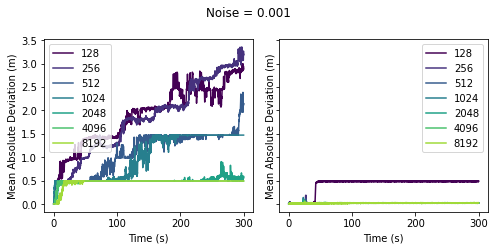

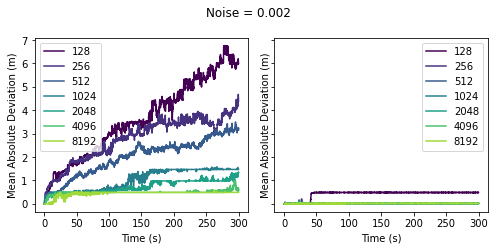

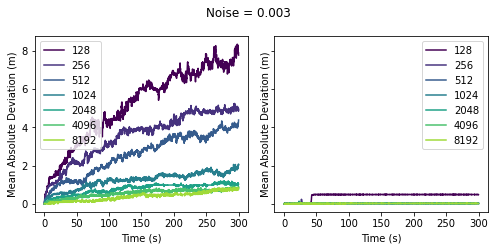

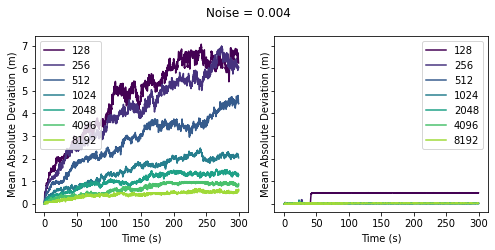

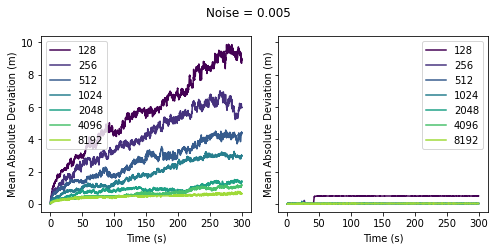

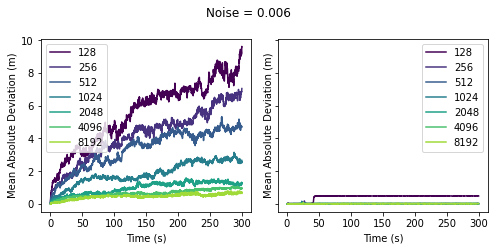

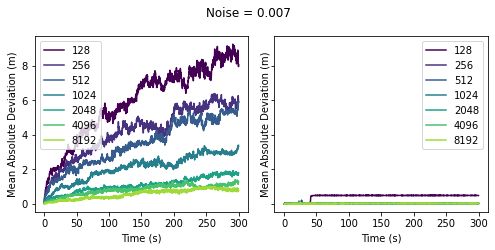

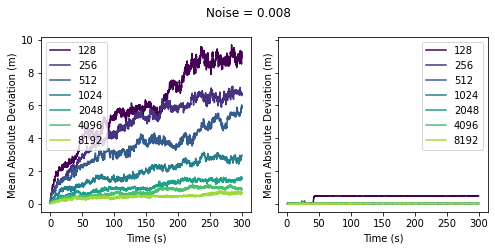

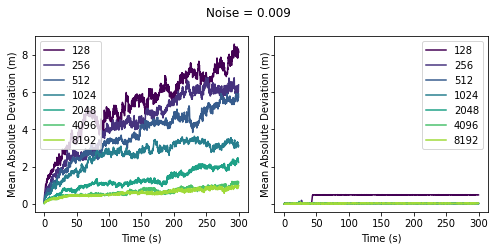

In [4]:
# Plot experimental conditions collated in combined plots
# Noise = 0.005 seems to be a nice choise
# The jump at the EC_LV_1 with N=128 corresponds to 0.622 neurons, so it is a jump to the middle in average

# Choose what to plot
plot_types = ['theta', 'abs_diff_mean', 'abs_diff_std']
plot_type = plot_types[1]                       # Choose what to plot 
                                                #       'theta': theta_ts_list, (In this version there is not much point of using this option because it will plot all network sizes in the same plot)
                                                #       'abs_diff_mean': theta_ts_abs_diff_mean, 
                                                #       'abs_diff_std': theta_ts_abs_diff_std

models = ['NMDA', 'EC_LV_1']  # List of the neuron models present in the collected recordings file
poisson_neuron_noises = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009] # List of the neuron noise present in the collected recordings file
neurons_nums = [128, 256, 512, 1024, 2048, 4096, 8192] # List of the network sizes present in the collected recordings file

model = models[0]                               # Choose which neuron model results to plot
poisson_neuron_noise = poisson_neuron_noises[0] # Choose what neuron noise results to plot
neurons_num = neurons_nums[0]                   # Choose which network size results to plot

# Mapping of the time series into a custom range (from theta={0,360} to eg m={0,100})
plot_mapping_units = 'Mean Absolute Deviation (m)'
plot_scale_mapping = [(0, 360), (0, 100)]
normalise_start = None
plot_from_t = None

# Colour scheme for plots
colourscheme = 'viridis' # 'viridis' or 'none'

if colourscheme == 'viridis':
    viridis = plt.cm.get_cmap('viridis')
    
for poisson_neuron_noise in poisson_neuron_noises:
    if SAVE_PLOT:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 3), sharex=True, sharey=True)
    else:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 3.5), sharex=True, sharey=True)

    for indx_i, model in enumerate(models):
        for indx_j, neurons_num in enumerate(neurons_nums):
            # Get reference to the appropriate subplot
            ax = axs[indx_i]
            # Get the list of theta recordings time series
            theta_ts_list = data[()][model][poisson_neuron_noise][neurons_num]['theta_ts_list']
            t_snapshots = data[()][model][poisson_neuron_noise][neurons_num]['t_snapshots']
            theta_ts_abs_diff_mean = data[()][model][poisson_neuron_noise][neurons_num]['theta_ts_abs_diff_mean']
            theta_ts_abs_diff_std = data[()][model][poisson_neuron_noise][neurons_num]['theta_ts_abs_diff_std']
            
            if not SAVE_PLOT:
                fig.suptitle('Noise = ' + str(poisson_neuron_noise))
            
            # In this version there is not much point of using this option because it will plot all network sizes in the same plot
            if plot_type == plot_types[0]: # Plot theta_ts_list
                ts_list, t_snaps = preprocess_time_series(theta_ts_list, t_snapshots, scale=plot_scale_mapping, plot_from_t=None, normalise_start=None)
                for i, ts in enumerate(ts_list):
                    ax.plot(t_snaps/second, ts)
                    ax.set_title('N = ' + str(neurons_num))
                    ax.set_xlabel('Time (s)')
                    #ax.set_ylim((0, 360))
                    ax.set_ylabel(plot_mapping_units)

            if plot_type == plot_types[1]: # Plot theta_ts_abs_diff_mean
                ts_list, t_snaps = preprocess_time_series(theta_ts_abs_diff_mean, t_snapshots, scale=plot_scale_mapping, plot_from_t=None, normalise_start=None)
                if colourscheme == 'viridis': 
                    colour = viridis(indx_j/len(neurons_nums))
                    ax.plot(t_snaps/second, ts_list, label=str(neurons_num), color=colour)
                else: 
                    ax.plot(t_snaps/second, ts_list, label=str(neurons_num))
                #ax.set_title('N = ' + str(neurons_num))
                ax.set_xlabel('Time (s)')
                ax.set_ylabel(plot_mapping_units)
                #ax.set_ylim((0, 360))
                ax.legend()

            if plot_type == plot_types[2]: # Plot theta_ts_abs_diff_std
                ts_list, t_snaps = preprocess_time_series(theta_ts_abs_diff_std, t_snapshots, scale=plot_scale_mapping, plot_from_t=None, normalise_start=None)
                if colourscheme == 'viridis': 
                    colour = viridis(indx_j/len(neurons_nums))
                    ax.plot(t_snaps/second, ts_list, label=str(neurons_num), color=colour)
                else:
                    ax.plot(t_snaps/second, ts_list, label=str(neurons_num))
                #ax.set_title('N = ' + str(neurons_num))
                ax.set_xlabel('Time (s)')
                ax.set_ylabel(plot_mapping_units)
                #ax.set_ylim((0, 360))
                ax.legend()

    fig.tight_layout()
    
    if SAVE_PLOT:
        fig.savefig(os.path.join(figs_path, 'pub_effect_of_net_size_on_dispersion_range100m' + '_noise' + str(poisson_neuron_noise) + figs_extension), bbox_inches='tight', dpi=300)
        

In [6]:
results_data = {}
for poisson_neuron_noise in poisson_neuron_noises:
    # Collect data for plot
    results_data[poisson_neuron_noise] = dict()
    print()
    print('Noise = ' + str(poisson_neuron_noise))
    for indx_i, model in enumerate(models):
        print()
        print(model + ' neuron model')
        print('=====================')
        trials_dict = data[()][model][poisson_neuron_noise]
        trials_dict_ammended = calc_theta_mean_absolute_deviation_rate(trials_dict, neurons_nums, start_time=0, end_time=200, percentage=0.1)
        print('---------------------')
        print('Not scaled output')
        print('---------------------')
        print_theta_mean_absolute_deviation_rate(trials_dict_ammended, neurons_nums, plot_key_str='Neurons', plot_key_units='number')
        #print_theta_mean_absolute_deviation_rate(trials_dict_ammended, neurons_nums, plot_key_str='Noise', plot_key_units='(1/SNR)')
        print('---------------------')
        print('Scaled output')
        print('---------------------')
        print_theta_mean_absolute_deviation_rate_scaled(trials_dict_ammended, neurons_nums, scale=[(0, 360), (0, 100)], plot_key_str='Neurons', plot_key_units='number')

        # Collect data for plot
        results_data[poisson_neuron_noise][model] = dict()
        results_data[poisson_neuron_noise][model]['x'] = []
        results_data[poisson_neuron_noise][model]['y'] = []
        for neurons_num in neurons_nums:
            results_data[poisson_neuron_noise][model]['x'].append(neurons_num)
            results_data[poisson_neuron_noise][model]['y'].append(trials_dict_ammended[neurons_num]['theta_mean_absolute_deviation_rate'])



Noise = 0.001

NMDA neuron model
---------------------
Not scaled output
---------------------
Neurons Drift rate
number    (°/s)   
    128 0.043680215363300266
    256 0.03757615646019708
    512 0.024892136708993037
   1024 0.026470588235293774
   2048 0.00882352941176464
   4096 0.00882352941176464
   8192 0.008823529411764355
---------------------
Scaled output
---------------------
Neurons Drift rate
number  (units/s) 
    128 0.012133393156472296
    256 0.010437821238943634
    512 0.006914482419164732
   1024 0.007352941176470493
   2048 0.0024509803921568445
   4096 0.0024509803921568445
   8192 0.0024509803921567656

EC_LV_1 neuron model
---------------------
Not scaled output
---------------------
Neurons Drift rate
number    (°/s)   
    128 0.008677845798198547
    256 0.0003307829440730359
    512 0.0003396533492142595
   1024 0.00039297812347399485
   2048 0.00031399072902871695
   4096 6.578317838958014e-05
   8192 0.00038481835768386927
---------------------
Scaled o

Max tolerable drift rate 0.034m/h (9.444444444444445e-06m/s)
Optimal parameters
y=a*exp(-b*x)+c, [a, b, c] = [53969.99166697   803.96323172   459.52886623]
R^2 = 0.9770318728519803
For ensuring drift of less than 0.034m/h (9.444444444444445e-06m/s) we need 54021 excitatory neurons
Optimal parameters
y=a*exp(-b*x)+c, [a, b, c] = [4.57660138e+03 6.87836485e+03 2.47305700e+00]
R^2 = 0.19796773169836457
For ensuring drift of less than 0.034m/h (9.444444444444445e-06m/s) we need 4291 excitatory neurons


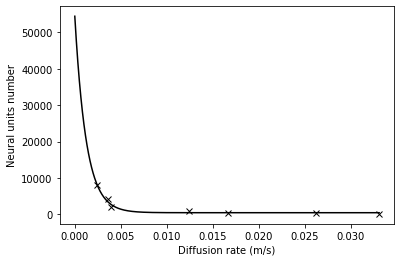

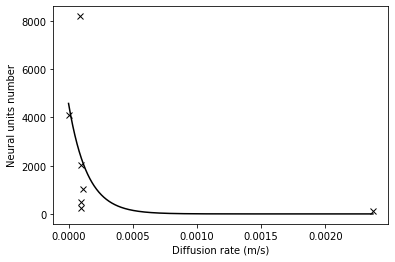

In [7]:
# New attempt
# Fit curves to the data points
# Drift rate in meters/sec

#plt.rcParams.update({'font.size': 14}) # Change the font size

# Requirements calculation:
t_req = 60 * 60 # Default t_req = 1h
drift_max_percent = 0.01 # Default 1%

# Set condition
condition = 2 # condition = 1 or 2: 1 is for 1m/100m while 2 for 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)
if condition == 1:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.01 # 1% => 1m/100m
if condition == 2:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.00034 # 0.034% => 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)

range_max = 360
range_max_new = 100

drift_max = drift_max_percent * range_max_new
drift_rate_max = drift_max / t_req
x_req = drift_rate_max
print('Max tolerable drift rate {}m/h ({}m/s)'.format(drift_max, drift_rate_max))

def func_exp(x, a, b, c):
    """ Exponential function """
    y = a * np.exp(-b*x) + c
    return y

# Plot only for 0.005 synaptic noise
poisson_neuron_noise = 0.005

for indx_i, model in enumerate(models):

    fig = plt.figure()
    
    x = np.array(results_data[poisson_neuron_noise][model]['y'])
    y = np.array(results_data[poisson_neuron_noise][model]['x'])
    x = scale_circ_to_line(x, scale=[(0, range_max), (0, range_max_new)])
    
    params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA':
        params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'EC_LV_1':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    
    params, conv  = curve_fit(func_exp, x, y, params0) # fit function parameters

    # Print the fitted parameters
    print('Optimal parameters')
    print('y=a*exp(-b*x)+c, [a, b, c] = {}'.format(params))

    # Calculate fitted curve prediction
    y_prime = func_exp(x, params[0], params[1], params[2])

    # Calculate r^2
    print('R^2 = {}'.format(r2_score(y, y_prime)))

    # Calculate required number of neurons
    y_req = func_exp(x_req, params[0], params[1], params[2])
    print('For ensuring drift of less than {}m/h ({}m/s) we need {} excitatory neurons'.format(drift_max, x_req, int(np.round(y_req))))

    # Plot data points
    #plt.plot(x, y, linestyle='', marker='.', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.plot(x, y, 'xk', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')

    # Plot fitted curve for more sample points to make it smooth
    #x_prime = np.linspace(np.min(x), np.max(x), num=1000, endpoint=True)
    max_lim = 1
    max_lim = np.max(x)
    x_prime = np.linspace(0, max_lim, num=1000, endpoint=True)

    # Calculate fitted curve prediction
    y_prime = func_exp(x_prime, params[0], params[1], params[2])
    #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.plot(x_prime, y_prime, '-k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')

    # 
    #plt.legend(loc='best')
    plt.xlabel('Diffusion rate (m/s)')
    plt.ylabel('Neural units number')
    #plt.xlim([0, max_lim])

    if SAVE_PLOT:
        plt.savefig(os.path.join('Data/Plots/', 'pub_' + model + '_net_size_vs_dispersion_rate_range' + str(range_max_new) + 'm' + figs_extension), bbox_inches='tight', dpi=300)
    

### For the EC_LV_1 neurons for more than 128 neurons any number of neurons does not produce significant difference in drift so all measurements appear vertically the one above the other so no good fitting can be made and it is not meaningfull. Because of this behaviour using the percentage value in the calc_theta_mean_absolute_deviation_rate() call produces wildly varying results. It works though as expected for the NMDA neurons. 

In [12]:
#import pandas as pd
#import copy 
## Reformat to 3D dict
#results_data_3D = copy.deepcopy(results_data)
#for k1 in results_data_3D.keys():
#    for k2 in results_data_3D[k1].keys():
#        for k_i, val in enumerate(results_data_3D[k1][k2]['x']):
#            results_data_3D[k1][k2][val] = scale_circ_to_line(results_data_3D[k1][k2]['y'][k_i], scale=[(0, 360), (0, 100)])
#        del results_data_3D[k1][k2]['x']
#        del results_data_3D[k1][k2]['y']
#
## Load the dict into a pandas data frame
## The dict structure is 
##     results_data_3D[poisson_neuron_noise][model][neurons_num] = drift_MAD_float
#df = pd.concat({k: pd.DataFrame(v).T for k, v in results_data_3D.items()}, axis=0)
#
## Set index names
#df.index.names = ['Noise', 'Model']
#df = df.reorder_levels(['Model', 'Noise'])
#
## Not sure how to do this; Scale the Noise values to the actual per neuron *1000
##df['Noise'] = df['Noise'].apply(lambda x: x*1000)
#
##df.columns.tolist()
#
## Sort index
#df.sort_index(inplace=True)
#df

In [8]:
import pandas as pd
import copy 
# Reformat to 3D dict
results_data_3D = []
for k1 in results_data.keys():
    for k2 in results_data[k1].keys():
        for k_i, key in enumerate(results_data[k1][k2]['x']):
            results_data_3D.append([k1, key, k2, scale_circ_to_line(results_data[k1][k2]['y'][k_i], scale=[(0, 360), (0, 100)])])
#results_data_3D
df4 = pd.DataFrame(results_data_3D, columns=['Noise', 'Neurons', 'Model', 'Drift'])
df4.set_index(['Model', 'Neurons'], inplace=True)

df4

Noise     Drift
Model   Neurons                 
NMDA    128      0.001  0.012133
        256      0.001  0.010438
        512      0.001  0.006914
        1024     0.001  0.007353
        2048     0.001  0.002451
...                ...       ...
EC_LV_1 512      0.009  0.000094
        1024     0.009  0.000072
        2048     0.009  0.000084
        4096     0.009  0.000080
        8192     0.009  0.000129

[126 rows x 2 columns]

In [9]:
def func_lin_1(x, a, b):
    """ Exponential function """
    y = a * x + b
    return y

def func_exp_1(x, a, b, c):
    """ Exponential function """
    y = a * np.exp(-b*x) + c
    return y

def func_exp_2(x, a, b, c, d):
    """ Exponential function """
    y = d - a * np.exp(-b*x) + c
    return y

def regress(data_x, data_y, func, params0, func_str = None, x_range_min=None, x_range_max=None):
    """
        data_x  : The x data point sample values to fit the function to
        data_y  : The y data point sample values to fit the function to
        func    : Function used for regression
        params0 : Initial guess of function parameter values to optimize
    """
    
    params, conv  = curve_fit(func, data_x, data_y, params0) # fit function parameters
    
    # Print the fitted parameters
    if func_str is not None:
        print('Optimal parameters')
        print(func_str.format(params))
    
    # Calculate fitted curve prediction
    y_prime = func(data_x, *params)
    # Calculate r^2
    print('R^2 = {}'.format(r2_score(data_y, y_prime)))
    
    # Return a fitted curve for enough sample points to make it smooth for plotting
    if x_range_min is None:
        x_range_min = np.min(data_x)
    if x_range_max is None:
        x_range_max = np.max(data_x)
    # Grenerate x axis values
    x_prime = np.linspace(x_range_min, x_range_max, num=1000, endpoint=True)
    # Calculate fitted curve prediction
    y_prime = func(x_prime, *params)
    
    return x_prime, y_prime


WARNING    /Users/john/Library/Python/3.7/lib/python/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
 [py.warnings]
WARNING    /Users/john/Library/Python/3.7/lib/python/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
 [py.warnings]


Optimal parameters
a*exp(-b*x)+c, [a, b, c] = [ 6.21168082e-02  1.06375809e+03 -6.68209374e+03  6.68212694e+03]
R^2 = 0.9171745998947933
Optimal parameters
a*exp(-b*x)+c, [a, b, c] = [ 3.56323004e-02  7.54177853e+02 -3.12900210e+04  3.12900478e+04]
R^2 = 0.9483988951635944
Optimal parameters
a*exp(-b*x)+c, [a, b, c] = [ 2.49885518e-02  5.20984905e+02  1.29900011e+05 -1.29899989e+05]
R^2 = 0.8162859427951992
Optimal parameters
a*exp(-b*x)+c, [a, b, c] = [ 9.48211253e-03  1.39309069e+02  2.99000075e+04 -2.98999926e+04]
R^2 = 0.601336119590417
Optimal parameters
a*exp(-b*x)+c, [a, b, c] = [ 6.14860022e-03  3.07041927e+02  9.89999924e+03 -9.89999190e+03]
R^2 = 0.6428449237209041


WARNING    /Users/john/Library/Python/3.7/lib/python/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
 [py.warnings]


Optimal parameters
a*exp(-b*x)+c, [a, b, c] = [ 2.88382638e-03  6.65310925e+02 -3.00999970e+04  3.01000009e+04]
R^2 = 0.3260038785789926
Optimal parameters
a*exp(-b*x)+c, [a, b, c] = [-1.99812065e-04  3.32310229e+03  2.11871807e+04 -2.11871780e+04]
R^2 = -0.0013785654995059904


Text(0, 0.5, 'Diffusion rate (m/s)')

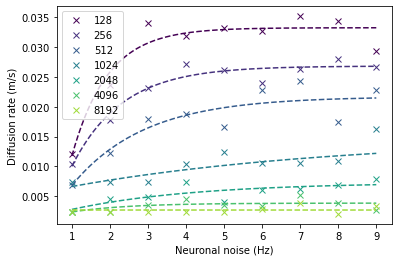

In [15]:
#df4.xs('NMDA').plot()
#df4.xs('NMDA').plot(x='Noise', y='Drift')
#df4.xs('NMDA').loc[128]['Noise']
#df4.xs('NMDA').loc[128]['Drift']
# Get the unique list of Neurons values and iterate
for indx_i, neurons in enumerate(np.unique(df4.xs('NMDA').index.values)):
    # For each Neurons value plot a Drift vs Noise plot
    x = df4.xs('NMDA').loc[neurons]['Noise']
    y = df4.xs('NMDA').loc[neurons]['Drift']
    x_prime, y_prime = regress(x, y, func_exp_2, [0.06, 1000.0, -100, 100], func_str = 'a*exp(-b*x)+c, [a, b, c] = {}')
    if colourscheme == 'viridis': 
        colour = viridis(indx_i/len(neurons_nums))
        plt.plot(x*1000, y, 'x', label=neurons, color=colour)
        plt.plot(x_prime*1000, y_prime, '--', color=colour)
    else:
        plt.plot(x*1000, y, 'x', label=neurons)
        plt.plot(x_prime*1000, y_prime, '--')
plt.legend()
plt.xlabel('Neuronal noise (Hz)')
plt.ylabel('Diffusion rate (m/s)')

Optimal parameters
a*x + b, [a, b] = [-0.00095526  0.00239384]
R^2 = 0.007896786397400435
Optimal parameters
a*x + b, [a, b] = [1.92142241e-04 9.49051364e-05]
R^2 = 0.013282931279982924
Optimal parameters
a*x + b, [a, b] = [-5.74039941e-05  9.38944777e-05]
R^2 = 0.0004886862871695818
Optimal parameters
a*x + b, [a, b] = [-0.00471639  0.00011768]
R^2 = 0.5535835350729872
Optimal parameters
a*x + b, [a, b] = [3.46360543e-04 9.16910329e-05]
R^2 = 0.018681035951013336
Optimal parameters
a*x + b, [a, b] = [5.66450990e-03 1.25527274e-05]
R^2 = 0.1882178226500123
Optimal parameters
a*x + b, [a, b] = [6.59713211e-04 9.04627055e-05]
R^2 = 0.011687361074450231


Text(0, 0.5, 'Diffusion rate (m/s)')

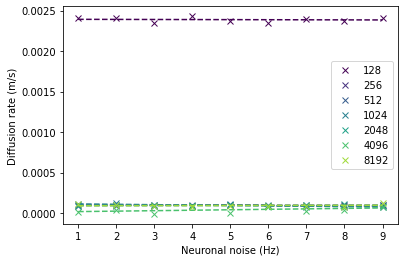

In [16]:
for indx_i, neurons in enumerate(np.unique(df4.xs('EC_LV_1').index.values)):
    # For each Neurons value plot a Drift vs Noise plot
    x = df4.xs('EC_LV_1').loc[neurons]['Noise']
    y = df4.xs('EC_LV_1').loc[neurons]['Drift']
    # Both the exponential and linear function regression give equally bad R^2 score
    #x_prime, y_prime = regress(x, y, func_exp_2, [0.06, 1.0, -1.0, 1.0], func_str = 'a*exp(-b*x)+c, [a, b, c] = {}')
    x_prime, y_prime = regress(x, y, func_lin_1, [0.01, 0.0], func_str = 'a*x + b, [a, b] = {}')
    if colourscheme == 'viridis': 
        colour = viridis(indx_i/len(neurons_nums))
        plt.plot(x*1000, y, 'x', label=neurons, color=colour)
        plt.plot(x_prime*1000, y_prime, '--', color=colour)
    else:
        plt.plot(x*1000, y, 'x', label=neurons)
        plt.plot(x_prime*1000, y_prime, '--')
plt.legend()
plt.xlabel('Neuronal noise (Hz)')
plt.ylabel('Diffusion rate (m/s)')